In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import ode_y, ode_y_jump_approach_one
from numba import njit

**ODE for y on (0, 2)**:
\begin{align*}
0 = \max_{\tilde{e}} \min_h &  -\delta \phi(y) + \delta \eta \log \tilde{e} \\
&+ \frac{d\phi(y)}{dy}\tilde{e}(\theta + \sigma_y \cdot h) + \frac{1}{2} \frac{d^2 \phi(y)}{(d y)^2}|\sigma_y|^2(\tilde{e})^2\\
&+ (\eta-1)(\gamma_1 + \gamma_2 y)\tilde{e}(\theta + \sigma_y \cdot h)\\
& +\frac{\xi_{1,m}}{2}h^\prime h -\xi_{2,m} \mathcal{I}(y) \log\sum_{j=1}^m \hat{\pi}_j^d \exp\left(\frac{1}{\xi_{2,m}}\left[\phi(y)-\phi_j(y)\right]\right)\\
\end{align*}

where
$$
\mathcal{I}(y) = \frac{1}{\sqrt{2\pi}\varsigma}\exp\{-\frac{(\bar{y}-y)^2}{2\varsigma^2}\}
$$
The FOC of $h$ gives:
$$
h^* = -\frac{\left(\frac{d\phi(y)}{dy} + (\eta-1)(\gamma_1 + \gamma_2 y )\right)\tilde{e}\sigma_y}{\xi_{1,m}}
$$


Substitute $h$ with $h^*$ in the ODE:

\begin{align*}
0 = \max_{\tilde{e}} & -\delta \phi(y) + \delta \eta \log \tilde{e} \\
& + G(y)\tilde{e}\theta + \frac{1}{2} \left(\frac{d^2 \phi(y)}{(d y)^2}-\frac{G^2(y)}{\xi_{1,m}}\right)|\sigma_y|^2(\tilde{e})^2\\
& -\xi_{2,m}\mathcal{I}(y) \log\sum_{j=1}^m \hat{\pi}_j^d \exp\left(\frac{1}{\xi_{2,m}}\left[\phi(y)-\phi_j(y)\right]\right)
\end{align*}

where $G(y):=\frac{d\phi}{dy} + (\eta-1)(\gamma_1 + \gamma_2 y)$

The FOC of $\tilde{e}$ gives:
$$
\tilde{e}^* = \frac{-\theta G(y) + \sqrt{\theta^2G^2(y)-4\delta \eta |\sigma_y|^2\left(\frac{d^2\phi(y)}{(dy)^2}-\frac{G^2(y)}{\xi_m}\right)}}{2|\sigma_y|^2\left(\frac{d^2\phi(y)}{(dy)^2}-\frac{G^2(y)}{\xi_m}\right)}
$$

In [2]:
# Model parameters
η = .032
δ = .01

θ = 1.86/1000.
σ_y = 1.2*1.86/1000.

ξ_1m = 1./4000
ξ_2m = 1./50

γ_1 = 1.7675/10000
γ_2 = 0.0022*2
y_bar = 2.

# three damages
γ_2p = np.array([0, .0197*2, .3853*2])
πd_o = np.array([.475, .475, .05])

# # two damages
# γ_2p = np.array([0, .0197*2])
# πd_o = np.array([.5, .5])

n_y = 100
y_grid_long = np.linspace(1e-10, 10, n_y)
y_grid_short = np.linspace(1e-10, 2, n_y)

In [3]:
# Prepare ϕ_i
ϕ = []
e_tilde = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, σ_y, ξ_1m, γ_1, γ_2, γ_2p_i, y_bar) 
    ϕ_i, e_tilde_i = ode_y(y_grid_long, model_paras, v0=None, ϵ=.5,
                           tol=1e-8, max_iter=10_000, print_all=False)
    ϕ.append(ϕ_i)
    e_tilde.append(e_tilde_i)

ϕ_i_list = []
for ϕ_i in ϕ:
    temp = np.interp(y_grid_short, y_grid_long, ϕ_i)
    ϕ_i_list.append(temp)
ϕ_i = np.array(ϕ_i_list)

Converged. Total iteration 2169: LHS Error: 9.985754802904756e-09; RHS Error 1.7771085521436263e-06
Converged. Total iteration 2110: LHS Error: 9.959926591807111e-09; RHS Error 4.610388643713211e-06
Converged. Total iteration 2358: LHS Error: 9.953523061323466e-09; RHS Error 2.0616815730679382e-05


In [5]:
# Compute ϕ
ς = .1
model_paras = (η, δ, θ, σ_y, ξ_1m, ξ_2m, ς, γ_1, γ_2, y_bar, ϕ_i, πd_o)
ϕ, e_tilde = ode_y_jump_approach_one(y_grid_short, model_paras, v0=ϕ_i[0], ϵ=.5,
                                     tol=1e-8, max_iter=1_000, print_all=False)

Converged. Total iteration 408: LHS Error: 9.913181178711206e-09; RHS Error 1.3830956067984596e-05


In [6]:
# Compute worst case probabilities
π = np.ones((len(πd_o), len(y_grid_short)))
for i in range(π.shape[0]):
    π[i] = πd_o[i]
πd_o_reshape = π
πd = np.exp(1./ξ_2m*(ϕ-ϕ_i[0])) / np.sum(πd_o_reshape*np.exp(1./ξ_2m*(ϕ-ϕ_i)), axis=0)*πd_o[i]

In [7]:
@njit
def simulation(y_grid, e_grid, π_grid, θ=1.86/1000., y_start=.5394, T=50):
    Et = np.zeros(T+1)
    πt = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        πt[i] = np.interp(y_start, y_grid, π_grid)
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, πt, yt

In [8]:
Et, πt, yt = simulation(y_grid_short, e_tilde, πd, θ=1.86/1000., y_start=.5394, T=85)

Text(0.5, 0, 'Year')

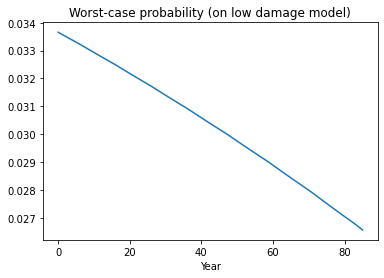

In [9]:
plt.plot(πt)
plt.title('Worst-case probability (on low damage model)')
plt.xlabel('Year')

Text(0.5, 0, 'Year')

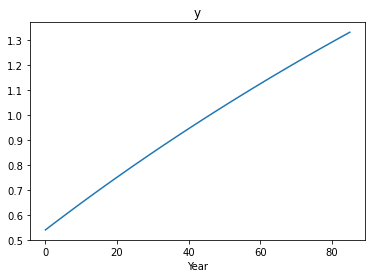

In [10]:
plt.plot(yt)
plt.title('y')
plt.xlabel('Year')

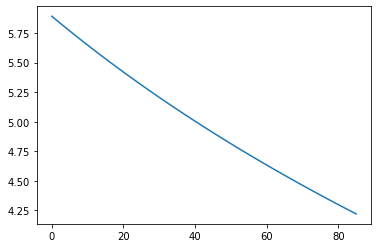

In [11]:
plt.plot(Et)